In [1]:
from glob import glob
from copy import deepcopy

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as spsp
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
import matplotlib.image as mpimg

from IPython.display import display, Markdown, Latex

In [2]:
nomimal_columns = [
    "i12_health_1",   # Worn mask outside
    "i12_health_2",   # Washed hands
    "i12_health_3",   # Used hand sanitiser
    "i12_health_4",   # Covered your nose and mouth when sneezing or coughing
    "i12_health_5",   # Avoided contact with people who have symptoms
    "i12_health_6",   # Avoided going out in general
    "i12_health_7",   # Avoided going to hospital or other
    "i12_health_8",   # Avoided taking public transport
    "i12_health_9",   # Avoided working outside your home
    "i12_health_10",  # Avoided letting your children go to school
    "i12_health_11",  # Avoided having guests to your home
    "i12_health_12",  # Avoided small social gatherings
    "i12_health_13",  # Avoided medium-sized social gatherings
    "i12_health_14",  # Avoided large-sized social gatherings
    "i12_health_15",  # Avoided crowded areas
    "i12_health_16",  # Avoided going to shops
    "i12_health_17",  # Slept in separate bedrooms
    "i12_health_18",  # Eaten separately at home
    "i12_health_19",  # Cleaned frequently touched surfaces
    "i12_health_20",  # Avoided touching objects in public
]

baselines = {
    # Common behaviours
    "i12_health_2":  2,  # Washed hands
    "i12_health_3":  2,  # Used hand sanitiser
    "i12_health_4":  2,  # Covered your nose and mouth when sneezing or coughing
    "i12_health_5":  2,  # Avoided contact with people who have symptoms
    "i12_health_8":  2,  # Avoided taking public transport
    # Specific behaviours
    "i12_health_1":  0,  # Worn mask outside
    "i12_health_6":  0,  # Avoided going out in general
    "i12_health_7":  0,  # Avoided going to hospital or other
    "i12_health_9":  0,  # Avoided working outside your home
    "i12_health_10": 0,  # Avoided letting your children go to school
    "i12_health_11": 0,  # Avoided having guests to your home
    "i12_health_12": 0,  # Avoided small social gatherings
    "i12_health_13": 0,  # Avoided medium-sized social gatherings
    "i12_health_14": 0,  # Avoided large-sized social gatherings
    "i12_health_15": 0,  # Avoided crowded areas
    "i12_health_16": 0,  # Avoided going to shops
    "i12_health_17": 0,  # Slept in separate bedrooms
    "i12_health_18": 0,  # Eaten separately at home
    "i12_health_19": 0,  # Cleaned frequently touched surfaces
    "i12_health_20": 0,  # Avoided touching objects in public
}

nomimal_columns_dict = {
    "i12_health_1": "Worn mask outside",
    "i12_health_2": "Washed hands frequently",
    "i12_health_3": "Used hand sanitiser",
    "i12_health_4": "Covered your nose and mouth when sneezing or coughing",
    "i12_health_5": "Avoided contact with people who have symptoms",
    "i12_health_6": "Avoided going out in general",
    "i12_health_7": "Avoided going to hospital or other",
    "i12_health_8": "Avoided taking public transport",
    "i12_health_9": "Avoided working outside your home",
    "i12_health_10": "Avoided letting your children go to school",
    "i12_health_11": "Avoided having guests to your home",
    "i12_health_12": "Avoided small social gatherings",
    "i12_health_13": "Avoided medium-sized social gatherings",
    "i12_health_14": "Avoided large-sized social gatherings",
    "i12_health_15": "Avoided crowded areas",
    "i12_health_16": "Avoided going to shops",
    "i12_health_17": "Slept in separate bedrooms",
    "i12_health_18": "Eaten separately at home",
    "i12_health_19": "Cleaned frequently touched surfaces",
    "i12_health_20": "Avoided touching objects in public",
}

# NOT TO BE IMPLEMENTED YET
value_colums = [
    "i13_health",  # how many times, would you say you washed your hands
]

nominal_to_value = {
    "Not at all": -1,  # Worst behaviour
    "Rarely" :   -.5,
    "Sometimes":   0,  # Common baseline
    "Frequently": .5,
    "Always":      1,  # Best behaviour
}

zone_regioni = {
"North west": ["Aosta","Liguria","Lombardy","Piedmont"],
"North east": ["Emilia-Romagna","Friuli-Venezia_Giulia","Trento","Bolzano","Veneto"],
"Centre": ["Lazio","Marche","Tuscany","Umbria"],
"South": ["Abruzzo","Apulia","Basilicata","Calabria","Campania","Molise"],
"Islands": ["Sardinia","Sicily"],
}

Qweek = {
    "week 0": pd.Timestamp("2020-02-04"),
    "week 1": pd.Timestamp("2020-04-03"),
    "week 2": pd.Timestamp("2020-04-08"),
    "week 3": pd.Timestamp("2020-04-16"),
    "week 4": pd.Timestamp("2020-04-25"),
    "week 5": pd.Timestamp("2020-05-01"),
    "week 6": pd.Timestamp("2020-05-07"),
    "week 7": pd.Timestamp("2020-05-14"),
    "week 8": pd.Timestamp("2020-05-28"),
    "week 9": pd.Timestamp("2020-06-10"),
}

In [3]:
colums_to_use = deepcopy(nomimal_columns)
colums_to_use.append("qweek")
colums_to_use.append("region")

data = pd.read_csv(
    "italy.csv",
    usecols=colums_to_use,
    index_col=["qweek", "region"],
    encoding="ISO-8859-1")

In [4]:
for nominal in nominal_to_value:
    data.replace(nominal, nominal_to_value[nominal], inplace=True)

In [5]:
data.replace(' ', 0, inplace=True)

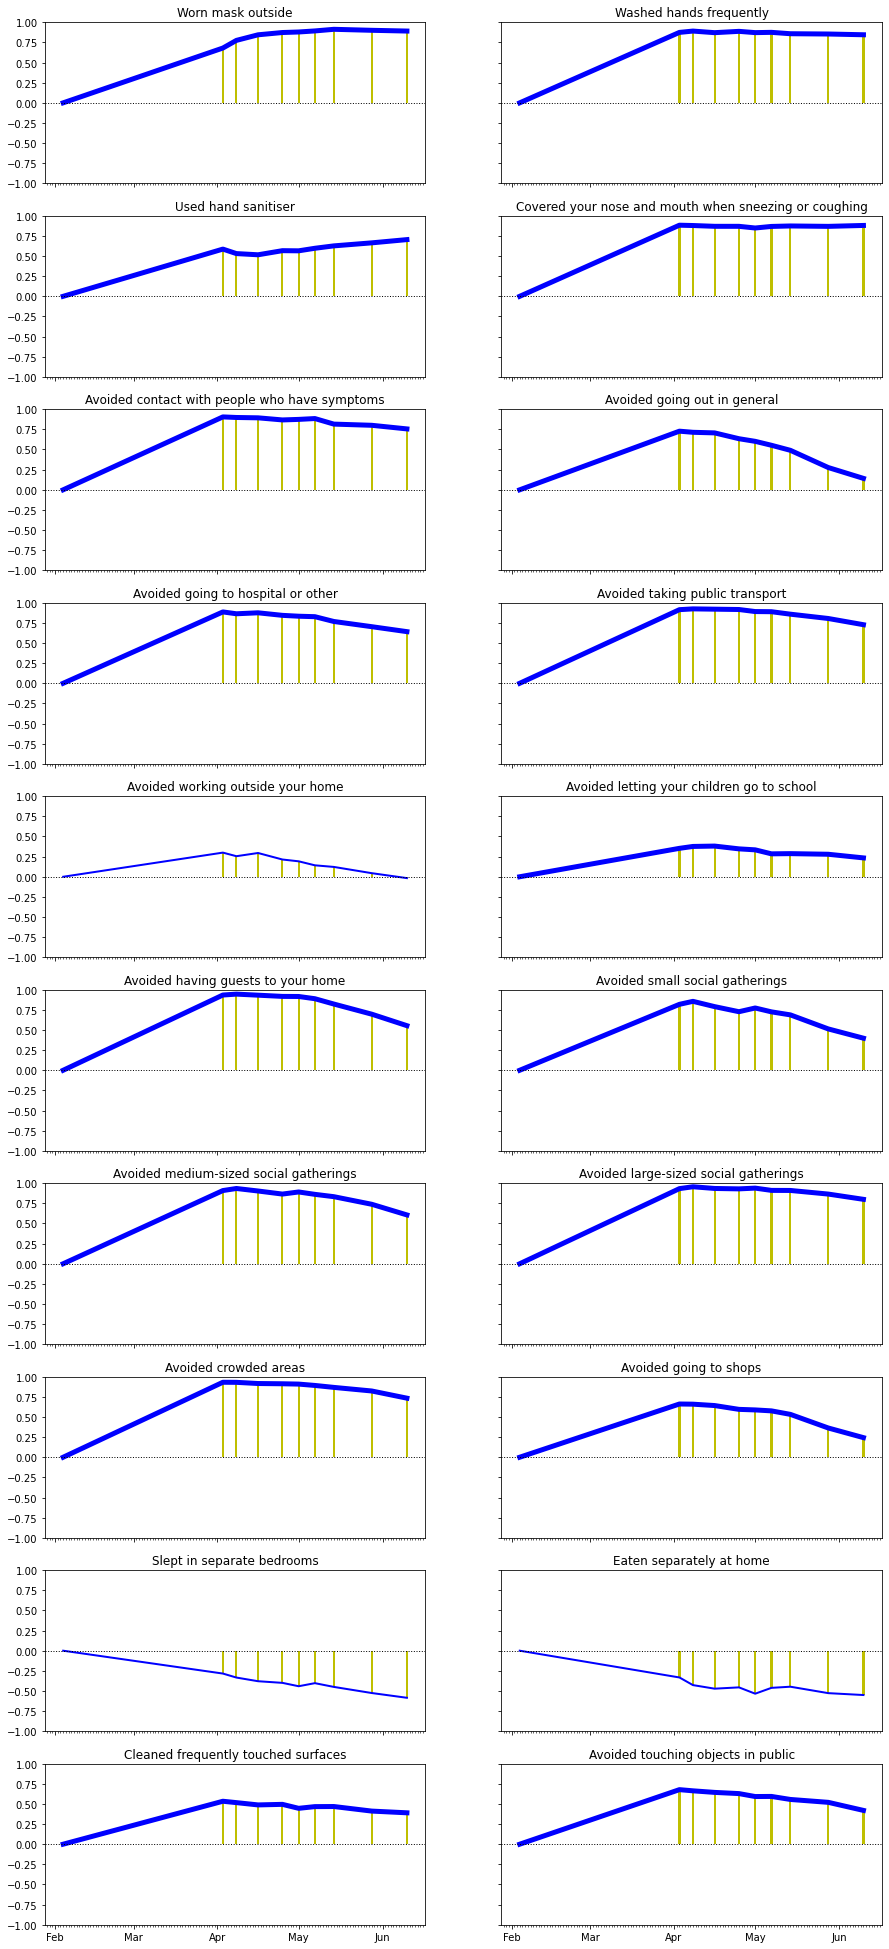

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(15, 35), sharex=True, sharey=True)

display_data = {}

i = 0
for nomimal_column in nomimal_columns:
    weeks = [Qweek["week 0"]]
    display_data.update({nomimal_column: []})
    display_data[nomimal_column].append(0)
    for idx, dt in data.groupby(level=0):
        weeks.append(Qweek[idx])
        display_data[nomimal_column].append(dt[nomimal_column].mean())
    if dt[nomimal_column].mean() > 0:
        lw=5
    else:
        lw=2
    ax.flat[i].bar(
        weeks, np.array(display_data[nomimal_column]),
        color="y"
    )
    ax.flat[i].plot(
        weeks, np.array(display_data[nomimal_column]),
        c="b", lw=lw
    )
    ax.flat[i].set_title(nomimal_columns_dict[nomimal_column])
    ax.flat[i].axhline(0, lw=1, ls=":", c="k")
    i += 1

ax[0,0].set_ylim(-1, 1)
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0,0].xaxis.set_minor_locator(mdates.DayLocator())
fig.set_facecolor('w')
plt.show();

In [7]:
data_df = pd.DataFrame(display_data, index=list(Qweek.values()))

In [8]:
data_df.index.name = "date"

In [9]:
upsampled_df = data_df.resample('D')

In [10]:
interpolated = upsampled_df.interpolate(method='polynomial', order=2)

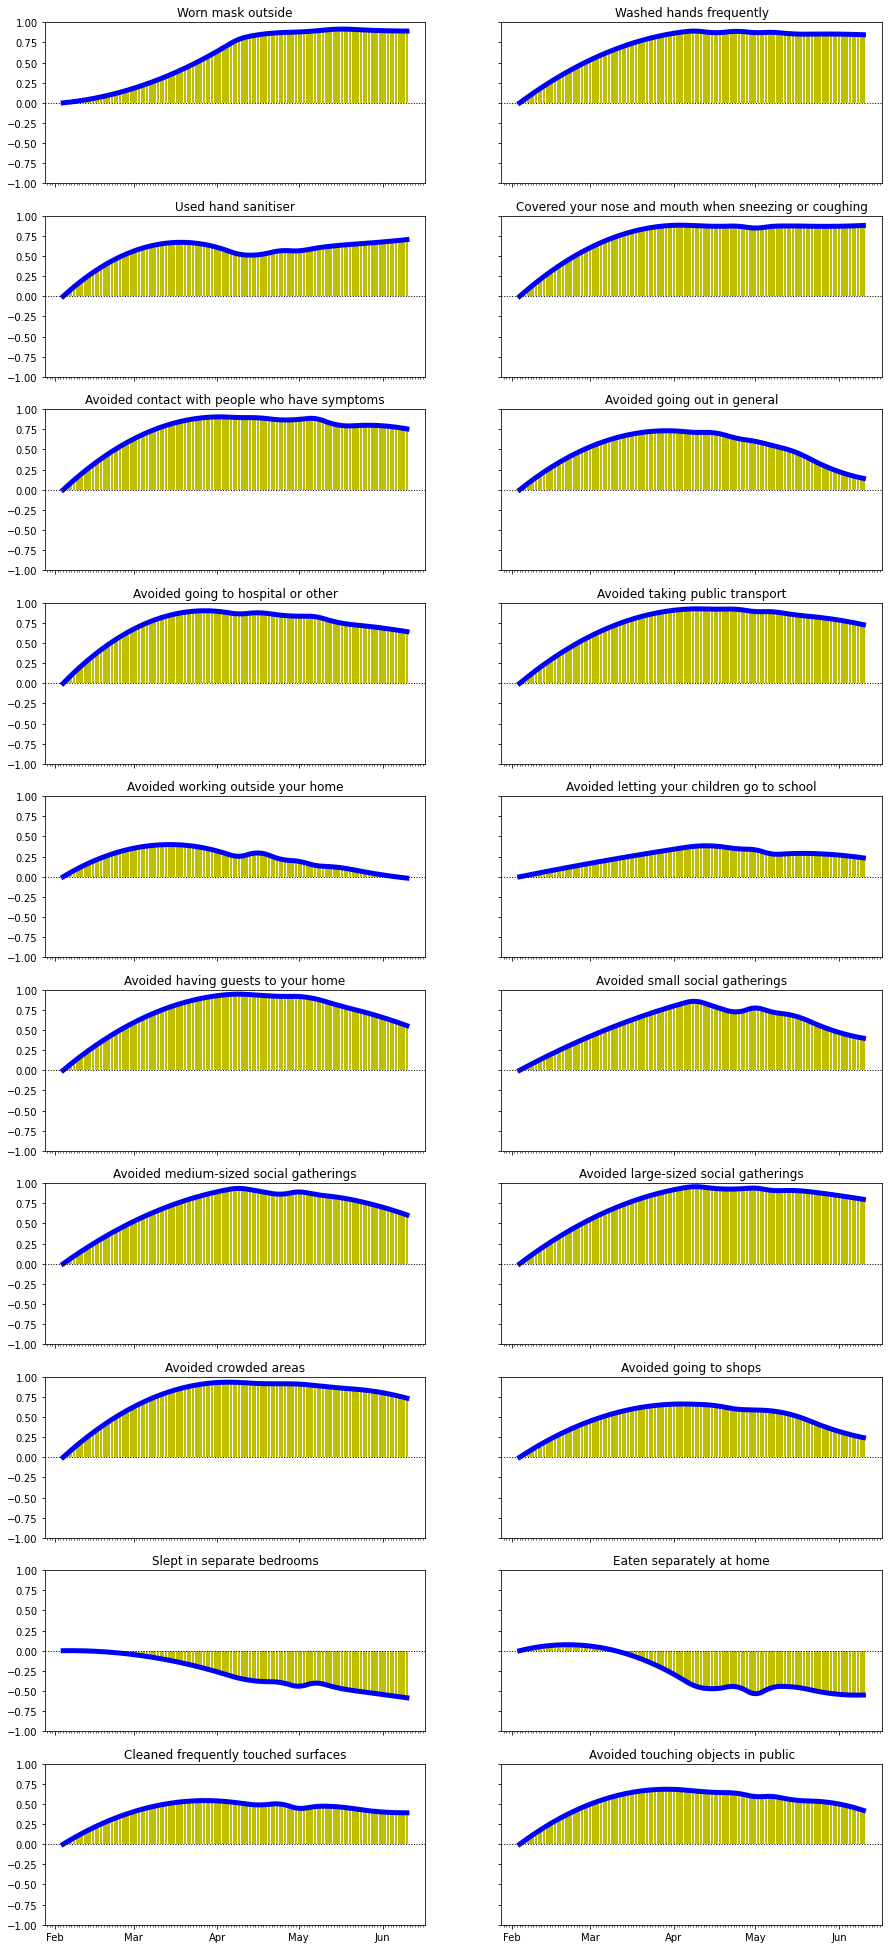

In [11]:
fig, ax = plt.subplots(10, 2, figsize=(15, 35), sharex=True, sharey=True)

i = 0
for nominal_column in nomimal_columns:
    ax.flat[i].plot(
        interpolated[nominal_column],
        c="b", lw=5
    )
    ax.flat[i].bar(
        interpolated[nominal_column].index,
        interpolated[nominal_column].values,
        color="y"
    )
    ax.flat[i].set_title(nomimal_columns_dict[nominal_column])
    ax.flat[i].axhline(0, lw=1, ls=":", c="k")
    i += 1

ax[0,0].set_ylim(-1, 1)
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0,0].xaxis.set_minor_locator(mdates.DayLocator())
fig.set_facecolor('w')
plt.show();

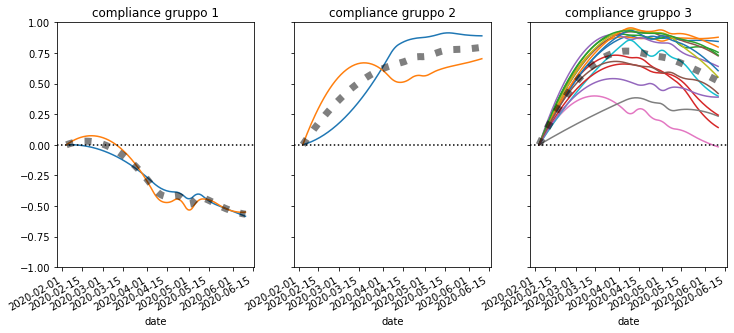

In [12]:
fig, ax = plt.subplots(1,3,figsize=(12, 5), sharey=True)

groups = {"1": [], "2": [], "3": []}
for nominal_column in nomimal_columns:
    if interpolated[nominal_column][-1] < -0.2:
        groups["1"].append(nominal_column)
        ax[0].plot(interpolated[nominal_column])
    elif interpolated[nominal_column][-1] > display_data[nominal_column][1]:
        groups["2"].append(nominal_column)
        ax[1].plot(interpolated[nominal_column])
    else:
        groups["3"].append(nominal_column)
        ax[2].plot(interpolated[nominal_column])

group1_mean = interpolated[groups["1"]].mean(axis=1)
group2_mean = interpolated[groups["2"]].mean(axis=1)
group3_mean = interpolated[groups["3"]].mean(axis=1)

pd.DataFrame(group1_mean).plot(ax=ax[0], ls=":", lw=7, c="k", alpha=.5, legend=False)
pd.DataFrame(group2_mean).plot(ax=ax[1], ls=":", lw=7, c="k", alpha=.5, legend=False)
pd.DataFrame(group3_mean).plot(ax=ax[2], ls=":", lw=7, c="k", alpha=.5, legend=False)

ax[0].set_ylim(-1, 1)

for i in range(3):
    ax[i].axhline(0, c="k", ls=":")
    ax[i].set_title(f"compliance gruppo {i+1}")

plt.show();

In [13]:
for idx in groups:
    lista = '\n- '.join(nomimal_columns_dict[n] for n in groups[idx])
    print(f"Compliance gruppo {idx} (parametri: {len(groups[idx])})")
    print(f"- {lista}")
    print()

Compliance gruppo 1 (parametri: 2)
- Slept in separate bedrooms
- Eaten separately at home

Compliance gruppo 2 (parametri: 2)
- Worn mask outside
- Used hand sanitiser

Compliance gruppo 3 (parametri: 16)
- Washed hands frequently
- Covered your nose and mouth when sneezing or coughing
- Avoided contact with people who have symptoms
- Avoided going out in general
- Avoided going to hospital or other
- Avoided taking public transport
- Avoided working outside your home
- Avoided letting your children go to school
- Avoided having guests to your home
- Avoided small social gatherings
- Avoided medium-sized social gatherings
- Avoided large-sized social gatherings
- Avoided crowded areas
- Avoided going to shops
- Cleaned frequently touched surfaces
- Avoided touching objects in public



In [14]:
df_dict = {
    "compliance1": group1_mean,
    "compliance2": group2_mean,
    "compliance3": group3_mean,
}
compliance_df = pd.DataFrame(df_dict)
compliance_df.index.name = "date"

In [15]:
compliance_df.to_csv("compliance.csv")

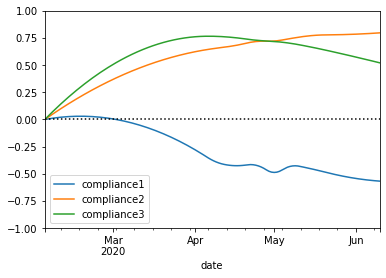

In [16]:
ax = compliance_df.plot()
plt.axhline(0, c="k", ls=":")
plt.ylim(-1, 1)
plt.show();